## Imports

In [83]:
# <hide-input>
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# <hide-input>
from datetime import datetime
import gc
import json
import math
import os
from pathlib import Path
import re
import subprocess
import sys
import time

import ipywidgets as widgets
from google.cloud import storage, bigquery
from google.cloud.bigquery import SchemaField
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm


AUTO = tf.data.experimental.AUTOTUNE
BUCKET = 'caleb-riiid'
DATASET = 'data'
LOCATION = 'europe-west4'
KAGGLE_SUBMIT_DATASET = 'riiid-submission-private'
PROJECT = 'fastai-caleb'
REPO = 'riiid_2020'
NOT_KAGGLE = os.getenv('KAGGLE_URL_BASE') is None

# if NOT_KAGGLE:
#     from google.colab import drive
#     DRIVE = Path('/content/drive/My Drive')
#     if not DRIVE.exists():
#         drive.mount(str(DRIVE.parent))
#     sys.path.append(str(DRIVE))
#     g_creds_path = 'credentials/riiid-caleb-faddd0c9d900.json'
#     os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(DRIVE/g_creds_path)

bucket = storage.Client(project=PROJECT).get_bucket(BUCKET)
dataset = bigquery.Dataset(f'{PROJECT}.{DATASET}')
bq_client = bigquery.Client(project=PROJECT, location=LOCATION)

if NOT_KAGGLE:
    CONFIG = json.loads(bucket.get_blob('config.json').download_as_string())
    os.environ = {**os.environ, **CONFIG}
    sys.path.append('/home/jupyter')
    from riiid_2020.bqhelpers import BQHelper
    from riiid_2020.queries import Queries

    from comet_ml import APIExperiment, Experiment
    from kaggle.api.kaggle_api_extended import KaggleApi
    kaggle_api = KaggleApi()
    kaggle_api.authenticate()

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
# pd.options.plotting.backend = 'plotly'
tqdm.pandas()

import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Classes

In [85]:
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, start=1e-7, end=5, steps=100):
        self.losses = []
        self.start = start
        self.end = end
        self.steps = steps
        self.best_loss = np.inf

    def on_batch_begin(self, step, logs):
        scheduled_lr = self.start * (self.end / self.start) ** (step/self.steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)

    def on_batch_end(self, step, logs):
        loss = logs.get('loss')
        self.losses.append(loss)

In [86]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, total_steps=1000, steps_up_pct=0.3, steps_across_pct=.01, steps_down_pct=0.6, lr_max=.001,
              lr_start_factor=.00003, lr_end_factor=.00001, decay=0.93,
              mo_max=0.95, mo_min=0.85, verbose=1):
        
        self.step = -1
        self.epoch = -1

        super(OneCycleScheduler, self).__init__()

        def one_cycle(step):
            
            steps_up = int(total_steps * steps_up_pct)
            steps_across = int(total_steps * steps_across_pct)
            steps_down = int(total_steps * steps_down_pct)
            lr_start = lr_max * lr_start_factor
            lr_end = lr_max * lr_end_factor

            if step <= steps_up:
                new_lr = (lr_max - lr_start)/2  * (-math.cos((math.pi * step) / steps_up) + 1) + lr_start
                new_mo = (mo_max - mo_min)/2  * (math.cos((math.pi * step) / steps_up) + 1) + mo_min
            
            elif step <= (steps_up + steps_across):
                new_lr = lr_max
                new_mo = mo_min
            
            elif step <= (steps_up + steps_across + steps_down):
                down_step = step - steps_across - steps_up
                new_lr = (lr_max - lr_end)/2  * (math.cos((math.pi * down_step) / steps_down) + 1) + lr_end
                new_mo = (mo_max - mo_min)/2  * (-math.cos((math.pi * down_step) / steps_down) + 1) + mo_min

            else:
                new_lr = lr_end * decay**(step - steps_up - steps_across - steps_down)
                new_mo = mo_max
            
            return new_lr, new_mo

        self.schedule = one_cycle
        self.verbose = verbose
 
    def on_batch_begin(self, step, logs):
        self.step +=1
        scheduled_lr, scheduled_mo = self.schedule(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        tf.keras.backend.set_value(self.model.optimizer.beta_1, scheduled_mo)
        
    def on_epoch_end(self, epoch, logs):
        if self.verbose:
            scheduled_lr, scheduled_mo = self.schedule(self.step)
            auc_roc = logs.get('val_auc_roc')
            auc_roc = auc_roc if auc_roc is not None else 0
            print(f'\nepoch {epoch+1:02d}: val_auc_roc={auc_roc:0.4f}, learning_rate={scheduled_lr:0.2e}, beta_1={scheduled_mo:0.3f}')
            
def plot_lr_sched(one_cycle, total_steps):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=list(range(total_steps)),
                   y=[one_cycle.schedule(e)[0] for e in range(total_steps)],
                   name="lr"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=list(range(total_steps)),
                   y=[one_cycle.schedule(e)[1] for e in range(total_steps)],
                   name="mom"),
        secondary_y=True,
    )

    fig.update_layout(title_text="Learning Rate Schedule")
    fig.update_xaxes(title_text="steps")
    fig.update_yaxes(title_text="learning rate", secondary_y=False)
    fig.update_yaxes(title_text="momentum", secondary_y=True)

    fig.show()

## Strategy

In [87]:
def get_strategy():

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver('tpu-1')
        print('Running on TPU ', tpu.master())
    except:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    
    else:
        strategy = tf.distribute.get_strategy()
        for d in tf.config.list_physical_devices():
            print(d)
            
    return strategy

strategy = get_strategy()

Running on TPU  grpc://10.165.92.218:8470
INFO:tensorflow:Initializing the TPU system: tpu-1


INFO:tensorflow:Initializing the TPU system: tpu-1


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Setup

In [88]:
dtypes=  {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool',
    'tid_orig': 'int16'
}

In [89]:
bqh = BQHelper(bucket, DATASET, bq_client)

In [90]:
folds = range(5)

## Attention 

### Datasets

In [91]:
df_trn_attn = bqh.get_df_query_bqs(f"""
    WITH t AS (
        SELECT fold, timestamp, user_id, content_id + 1 content_id, answered_correctly + 1 answered_correctly,
        MAX(task_container_id) OVER(PARTITION BY user_id) tid_max
        FROM data.train
        WHERE content_type_id = 0
    )
    SELECT fold, timestamp, user_id, content_id, answered_correctly
    FROM t
    WHERE tid_max > 9
    AND fold in ({(',').join(map(str,folds))});
""",'df_trn_attn.pkl', from_bq=False, dtypes=dtypes)

In [92]:
NUM_Q = df_trn_attn.content_id.max() + 1
NUM_A = df_trn_attn.answered_correctly.max() + 1
LEN_SEQ = 100

In [93]:
def get_seq(group, max_seq_len=LEN_SEQ):
    q, a = group
    pad_len = max(max_seq_len - len(q), 0)
    tq = tf.concat([tf.zeros(pad_len, dtype=tf.int64), tf.constant(q[:max_seq_len], dtype=tf.int64)], axis=0)
    ta = tf.concat([tf.zeros(pad_len, dtype=tf.int64), tf.constant(a[:max_seq_len], dtype=tf.int64)], axis=0)
    return tq, ta

In [94]:
def add_masks_to_batch(features, labels):
    seq = tf.cast(tf.math.equal(features, 0), tf.float32)
    pad_mask_enc = seq[:, tf.newaxis, tf.newaxis, :]
    pad_mask_dec = tf.identity(pad_mask_enc)
        
    size = tf.shape(labels)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    combined_mask = tf.maximum(pad_mask_dec, look_ahead_mask)
        
    return  features, pad_mask_enc, combined_mask, pad_mask_dec, labels

In [95]:
def get_ds(df, batch_size, repeat=True, shuffle=True):
    group = (df[['user_id', 'content_id', 'answered_correctly']]
             .groupby('user_id').apply(lambda r: ( r['content_id'].values,
                                              r['answered_correctly'].values)))
    q_seq, a_seq = zip(*map(get_seq, group))
    t_slices = (tf.stack(q_seq, axis=0), tf.stack(a_seq, axis=0))
    ds = tf.data.Dataset.from_tensor_slices(t_slices).shuffle(1000)
    ds = ds.repeat() if repeat else ds
    ds = ds.batch(batch_size) #.map(add_masks_to_batch, num_parallel_calls=AUTO)
    
    return ds.prefetch(AUTO)

### Positional Encoding 

In [96]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

In [97]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [98]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

* query, key and value matrices are trainable weights
* 
* question code --> embedding --> multiplied by querys and keys, which I believe are trainable weights, to produce a combination of attention weights and values for each word(question in this case) in the sequence.

### Dot Product Attention

In [99]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [52]:
#what gets returned are the weighted values for each word in the sequence along
#with the weights that were applied to the values to get the weighted values
#the weights were determined by multiplying the embedding representation of each
#word three trainable matrices, q, k, v, and then multiplying q x k.
# embed x (Q, K, V) --> q, k, v --> weights = softmax(q x k)/scaled  --> weighted values = weights * values

In [100]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [101]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

NotFoundError: '_MklMatMul' is neither a type of a primitive operation nor a name of a function registered in binary running on n-548b2f10-w-0. Make sure the operation or function is registered in the binary running in this process.

In [102]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights

In [103]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

# d_model = 512, depth = 64
# split d_model weights in to num_heads x d_model/depth matrices
# calc output and weights for each head
# weights for each head include a weight for each position in the sequence for 
# every position in the sequence
# concat the output back together to have the same depth as the model again
# so you essentially have 8 sets of output for each position in the sequence
# and then run that through a dense layer to decide how to weight each of the d_model
# values returned in the concat

out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

NotFoundError: '_MklMatMul' is neither a type of a primitive operation nor a name of a function registered in binary running on n-548b2f10-w-0. Make sure the operation or function is registered in the binary running in this process. [Op:BiasAdd]

In [106]:
#dff means depth of feadforward
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [107]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        # (batch_size, input_seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [59]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [108]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # (batch_size, target_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        # (batch_size, target_seq_len, d_model)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        # (batch_size, target_seq_len, d_model)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [61]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [109]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [63]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [110]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(
            maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [111]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

NotFoundError: '_MklMatMul' is neither a type of a primitive operation nor a name of a function registered in binary running on n-548b2f10-w-0. Make sure the operation or function is registered in the binary running in this process. [Op:BiasAdd]

In [112]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):

        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [67]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [68]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = NUM_Q
target_vocab_size = NUM_A
dropout_rate = 0.1

In [113]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [70]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

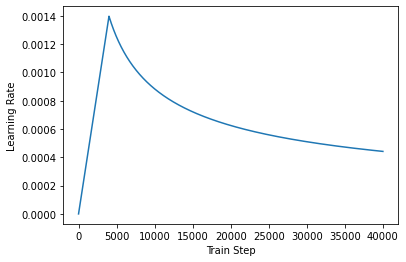

In [71]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [72]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [73]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [74]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Training

In [75]:
if False:
    transformer = Transformer(num_layers, d_model, num_heads, dff,
                              input_vocab_size, target_vocab_size, 
                              pe_input=10000, 
                              pe_target=10000,
                              rate=dropout_rate)

In [76]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 2
folds_trn, folds_val = folds[1:], folds[:1]

num_ex_trn = df_trn_attn.fold.isin(folds_trn).sum()
num_ex_val = df_trn_attn.fold.isin(folds_val).sum()
steps_per_epoch = num_ex_trn // BATCH_SIZE
steps_val = num_ex_val // BATCH_SIZE
steps_per_epoch

77472

In [78]:
if False:
    checkpoint_path = "./checkpoints/train"

    ckpt = tf.train.Checkpoint(transformer=transformer,
                               optimizer=optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')

In [79]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [80]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [81]:
results = {m: [] for m in ['loss', 'accuracy', 'duration']}

In [82]:
if False:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        # inp -> portuguese, tar -> english
        for (batch, (inp, tar)) in enumerate(ds_trn):
            train_step(inp, tar)

            if batch % 50 == 0:
                print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                    epoch + 1, batch, train_loss.result(), train_accuracy.result()))

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                ckpt_save_path))

        print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                            train_loss.result(),
                                                            train_accuracy.result()))

        print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

### TPU

In [117]:
with strategy.scope():
    transformer = Transformer(num_layers, d_model, num_heads, dff,
                              input_vocab_size, target_vocab_size,
                              pe_input=10000,
                              pe_target=10000,
                              rate=dropout_rate)

    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                         epsilon=1e-9)

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

    def accuracy_function(real, pred):
        accuracies = tf.equal(real, tf.argmax(pred, axis=2))

        mask = tf.math.logical_not(tf.math.equal(real, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [118]:
@tf.function
def train_step(transformer, optimizer, loss_function, train_loss, ds_iter, steps_per_epoch):
    def train_step_fn(inp, tar):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            inp, tar_inp)

        with tf.GradientTape() as tape:
            predictions, _ = transformer(inp, tar_inp,
                                         True,
                                         enc_padding_mask,
                                         combined_mask,
                                         dec_padding_mask)
            loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        
    for _ in tf.range(steps_per_epoch):
        strategy.run(train_step_fn, next(ds_iter))

In [119]:
ds_trn = get_ds(df_trn_attn[df_trn_attn.fold == 0], BATCH_SIZE)
ds_trn_iter = iter(strategy.experimental_distribute_dataset(ds_trn))

for epoch in range(EPOCHS):
    print(f'epoch: {epoch}, train_loss: {train_loss.result()}')
    train_loss.reset_states()
    epoch_start = time.perf_counter()
    train_step(transformer, optimizer, loss_function, train_loss, ds_trn_iter, steps_per_epoch)

epoch: 0, train_loss: 0.0
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


epoch: 1, train_loss: 0.5655438899993896


## Tensorflow Collaborative Filtering

In [ ]:
folds = range(40)

if False:
    df_data = pd.read_gbq((f"""
        WITH data AS (
        SELECT row_id, user_id, content_id, part, tags_array, answered_correctly,
        ROW_NUMBER() OVER(PARTITION BY user_id, content_id ORDER BY timestamp DESC) row_num
        FROM {DATASET}.train t
        JOIN {DATASET}.folds f
        ON t.user_id = f.user_id_s
        JOIN {DATASET}.content_tags c
        ON t.ql_id = c.ql_id
        WHERE content_type_id = 0
        AND t.task_container_id < f.task_container_id_min
        AND f.fold in ({(', '.join(list(map(str, folds))))}) 
        )
        SELECT row_id, user_id, content_id, part, tags_array, answered_correctly
        FROM data
        WHERE row_num = 1
        """, '_q_'), use_bqstorage_api=True, progress_bar_type='tqdm_notebook')        

In [ ]:
if False:
    df_data = pd.read_gbq((f"""
        WITH data AS (
        SELECT row_id, user_id, content_id, answered_correctly,
        ROW_NUMBER() OVER(PARTITION BY user_id, content_id ORDER BY timestamp DESC) row_num
        FROM {DATASET}.train t
        JOIN {DATASET}.folds f
        ON t.user_id = f.user_id_s
        WHERE content_type_id = 0
        )
        SELECT row_id, user_id, content_id, answered_correctly
        FROM data
        WHERE row_num = 1
        """, '_q_'), use_bqstorage_api=True, progress_bar_type='tqdm_notebook')

In [ ]:
folds = [0,1]

if True:
    df_test = pd.read_gbq((f"""
        SELECT row_id, user_id, content_id, part, tags_array, answered_correctly,
        FROM {DATASET}.train t
        JOIN {DATASET}.content_tags c
        ON t.ql_id = c.ql_id
        WHERE content_type_id = 0
        AND fold in ({(', '.join(list(map(str, folds))))}) 
        ORDER BY user_id, content_id
        """, '_q_'), use_bqstorage_api=True, progress_bar_type='tqdm_notebook')

In [ ]:
# keeping out unseen users and questions to start with
df_test = df_test[df_test.user_id.isin(df_data.user_id)
                    & df_test.content_id.isin(df_data.content_id)]

In [ ]:
df_ct = bq_client.query('select * from data.content_tags where question_id is not null').to_dataframe()
df_ct.question_id = df_ct.question_id.astype('category')
df_ct = df_ct.set_index('question_id')

In [ ]:
def fix_len(r):
    new = np.repeat(188, 6)
    new[range(len(r))] = r
    return new

In [ ]:
df_ct['tags'] = df_ct.tags_array.progress_apply(fix_len)

In [ ]:
all_tags = np.unique(np.concatenate(df_ct.tags_array))

In [ ]:
tag_cols = [f'tag_{t}' for t in range(6)]

In [ ]:
df_tags = pd.DataFrame(df_ct.tags.to_list(), columns=tag_cols)

In [ ]:
cat_cols = ['user_id', 'content_id', 'part']

In [ ]:
def categorify(df_data, df_test, df_tags, cat_cols, tag_cols):
    df_data = df_data.merge(df_tags, how='left', left_on='content_id', right_index=True)
    df_test = df_test.merge(df_tags, how='left', left_on='content_id', right_index=True)

    for col in cat_cols:        
        df_data[col] = df_data[col].astype('category')
        df_test[col] = pd.Categorical(df_test[col], df_data[col].cat.categories)

    for t in tag_cols:
        df_data[t] = pd.Categorical(df_data[t], all_tags)
        df_test[t] = pd.Categorical(df_test[t], all_tags)
        
    for col in cat_cols + tag_cols:
        df_data[col] = df_data[col].cat.codes
        df_test[col] = df_test[col].cat.codes
    
    train_cols = ['row_id'] + cat_cols + tag_cols + ['answered_correctly']

    return df_data[train_cols].sample(frac=1, random_state=42), df_test[train_cols]

In [ ]:
df_train, df_valid = categorify(df_data, df_test, df_tags, cat_cols, tag_cols)

### Dataset from DataFrames

In [ ]:
def get_ds(df, batch_size=1024, repeat=True):
    row_id = df.pop('row_id')
    y = df.pop('answered_correctly')   
    ds = tf.data.Dataset.from_tensor_slices(df, y)
    ds = ds.shuffle(int(5e6))
    ds = ds.repeat() if repeat else ds
    ds = ds.batch(batch_size)
    return ds.prefetch(AUTO)

### Dataset from TFRecords

In [ ]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    
    if type(value) != type(list()):
        value = [value]

    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [ ]:
def serialize_example(rec):
    
    feature = {
        'row_id': _int64_feature([rec[0]]),
        'features': _int64_feature(list(rec[1:-1])),
        'target': _int64_feature([rec[-1]])
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

In [ ]:
def parse_example(example, test=False):
    features = {'row_id': tf.io.FixedLenFeature([], tf.int64),
                'features': tf.io.FixedLenFeature([9], tf.int64),
                'target': tf.io.FixedLenFeature([], tf.int64),
                }

    example = tf.io.parse_single_example(example, features)

    return example['features'], example['target']

In [ ]:
def get_ds_tfrec(split, batch_size=4096, repeat=True):
    file_pat = f'gs://{BUCKET}/tfrecords/deep_collab-{split}*.tfrec'
    options = tf.data.Options()
    
    ds = (tf.data.Dataset.list_files(file_pat, shuffle=True)
          .with_options(options)
          .interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
          .map(parse_example, num_parallel_calls=AUTO)
          )
    
    ds = ds.shuffle(int(1e6))
    ds = ds.repeat() if repeat else ds
    ds = ds.batch(batch_size)
    return ds.prefetch(AUTO)

In [ ]:
parse_example(serialize_example(df_valid.head().to_numpy()[0]))

In [ ]:
if False:

    split_dict = {
        'train': df_train,
        'valid': df_valid
    }

    for s in split_dict:
        df = split_dict[s]
        n_files = len(df) // int(1e6)

        for i, split in enumerate(np.array_split(df, n_files)):
            out_path = f'gs://{BUCKET}/tfrecords'
            filename = f'deep_collab-{s}-{i:02d}-{len(split)}.tfrec'
            record_file = f'{out_path}/{filename}'

            with tf.io.TFRecordWriter(record_file) as writer:
                for rec in tqdm(split.to_numpy()):
                    writer.write(serialize_example(rec))

### Model

In [ ]:
embed_spec = {
    'user_id': (343810, 600, 0),
    'content_id': (13513, 300, 1),
    'part': (7, 5, 2),
    'tags': (189, 30, slice(3,9))
    }

class KnowledgeNet(tf.keras.Model):
    def __init__(self, embed_spec, n_act, l2_reg=1e-6, **kwargs):
        super(KnowledgeNet, self).__init__(**kwargs)
        self.embed_spec = embed_spec
        self.n_act = n_act
        self.l2_reg = l2_reg
        self.embed_dict = {}
        
        for k, v in self.embed_spec.items():
            input_dim, output_dim, _ = v
            self.embed_dict[k] = tf.keras.layers.Embedding(
                input_dim, output_dim,
                embeddings_initializer="he_normal",
                embeddings_regularizer=tf.keras.regularizers.l2(self.l2_reg),
                name=f'{k}_embedding'
            )
                        
        self.dense_1 = tf.keras.layers.Dense(
            input_dim=sum([v[0] for v in self.embed_spec.values()]), units=n_act, activation='relu', use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros', kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg),
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
            bias_constraint=None, name='dense_1'
        )
        
        self.dense_2 = tf.keras.layers.Dense(
            input_dim=n_act, units=1, activation='sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros', kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg),
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
            bias_constraint=None, name='dense_1'
        )
        
    def call(self, inputs):
        embeds = [self.embed_dict[k](inputs[:,v[-1]]) for k, v in self.embed_spec.items() if k != 'tags']
        embed_tags = self.embed_dict['tags'](inputs[:,self.embed_spec['tags'][-1]])
        embed_tags_agg = tf.reduce_prod(embed_tags, axis=1)
        x = self.dense_1(tf.concat(embeds + [embed_tags_agg], axis=1))        
        return self.dense_2(x)

In [ ]:
with strategy.scope():
    model = KnowledgeNet(embed_spec, 1024)
    opt = tf.keras.optimizers.Adam(lr=.0001)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    metrics = ['binary_accuracy', 'AUC']
    model.compile(loss=loss_fn, optimizer=opt, metrics=metrics)

In [ ]:
epochs = 2
batch_size = 2048 * strategy.num_replicas_in_sync
split_counts = {'train': 0, 'valid': 0}

for s in split_counts:
    for b in bucket.list_blobs(prefix=f'tfrecords/deep_collab-{s}'):
        split_counts[s] += int(b.name.split('-')[3].split('.')[0])

steps_per_epoch = split_counts['train'] // batch_size
val_steps = split_counts['valid'] // batch_size
total_steps = steps_per_epoch * epochs

split_counts, steps_per_epoch, val_steps, total_steps

In [ ]:
if False:
    lr_finder = LRFinder(start=1e-7, end=0.1, steps=100)

    with strategy.scope():
        model.save_weights(f'gs://{BUCKET}/temp/temp-weights.ckpt')
        model.fit(get_ds_tfrec('train', batch_size), steps_per_epoch=lr_finder.steps, callbacks=[lr_finder])
        model.load_weights(f'gs://{BUCKET}/temp/temp-weights.ckpt')

    x = [lr_finder.start * (lr_finder.end / lr_finder.start) ** (s/lr_finder.steps) for s in range(lr_finder.steps)]

In [ ]:
px.line(x=x, y=lr_finder.losses, log_x=True)

In [ ]:
reference_lr = .0001
print(f'max_lr: {reference_lr:1.2e}')

one_cycle_kwargs = dict(
    total_steps=total_steps,
    steps_up_pct=0.3,
    steps_across_pct=.01,
    steps_down_pct=0.6,
    lr_max=reference_lr,
    lr_start_factor=1/25,
    lr_end_factor=1/10,
    decay=0.9999,
    mo_max=0.95,
    mo_min=0.85,
    verbose=1
)


one_cycle = OneCycleScheduler(**one_cycle_kwargs)
plot_lr_sched(one_cycle, total_steps)

In [ ]:
history = model.fit(
    get_ds_tfrec('train', batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=get_ds_tfrec('valid', batch_size),
    validation_steps=val_steps,
    callbacks=[one_cycle],
    verbose=1
)

In [ ]:
model.summary()

In [ ]:
model.save(f'gs://{BUCKET}/models/deep_collab_model', include_optimizer=True)

In [ ]:
model = tf.saved_model.load(f'gs://{BUCKET}/models/collab_model_all')

In [ ]:
weights = {c: df_data[c].cat.categories for c in cat_cols}
for v in model.variables:
    name = v.name.split('/')[1]
    weights[name] = v.numpy()
    weights[name] = np.append(weights[name], np.mean(weights[name], axis=0))

In [ ]:
def get_pred(u_code, c_code, logits=False):
    user_vector = weights['user_embedding'][u_code]
    user_bias = weights['user_bias'][u_code]
    question_vector = weights['question_embedding'][c_code]
    question_bias = weights['question_bias'][c_code]
    
    logit = np.squeeze((user_vector * question_vector).sum() + user_bias + question_bias)
    
    if logits:
        return logit
    else:
        return 1 / (1 + np.math.exp(-logit))

In [ ]:
np.save('weights_all.npy', weights, allow_pickle=True)

In [ ]:
weights = np.load('weights_all.npy', allow_pickle=True).item()

In [ ]:
bucket.blob('weights_all.npy').upload_from_filename('weights_all.npy')

In [ ]:
def get_code_cols(df):
    return pd.concat([df[col].cat.codes for col in cat_cols], axis=1)

In [ ]:
df_cat_cols = get_code_cols(df_train)

In [ ]:
tqdm.pandas()

In [ ]:
get_pred(43124, 9276, True)

In [ ]:
df_preds = df_cat_cols.progress_apply(lambda r: get_pred(*r, logits=True), axis=1)

In [ ]:
roc_auc_score(df_valid.answered_correctly, df_preds)

In [ ]:
folds = range(5)

df_test_all = pd.read_gbq((f"""
    SELECT row_id, user_id, content_id, answered_correctly,
    FROM data.train t
    WHERE content_type_id = 0
    AND fold in ({(', '.join(list(map(str, folds))))}) 
    ORDER BY user_id, content_id
    """, '_q_'), use_bqstorage_api=True, progress_bar_type='tqdm_notebook')

In [ ]:
df_test_all.to_pickle('df_test_all.pkl')

In [ ]:
for c in cat_cols:
    df_test_all[c] = pd.Categorical(df_test_all[c], categories=weights[c])

In [ ]:
df_code_cols = get_code_cols(df_test_all)

In [ ]:
preds_all = df_code_cols.progress_apply(lambda r: get_pred(*r, logits=True), axis=1)

In [ ]:
df_test_all['pred_collab_logit'] = preds_all

In [ ]:
df_test_all[['row_id', 'pred_collab', 'pred_collab_logit']].to_pickle('df_pred_collab.pkl')

In [ ]:
bucket.blob('df_pred_collab.pkl').upload_from_filename('df_pred_collab.pkl')

In [ ]:
roc_auc_score(df_test_all.answered_correctly, preds_all)

## Custom Training Loop

In [ ]:
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE_GLOBAL = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

ds_trn_fit_iter = iter(strategy.experimental_distribute_dataset(get_ds_tfrec('train', batch_size=BATCH_SIZE_GLOBAL)))
ds_val_fit_iter = iter(strategy.experimental_distribute_dataset(get_ds_tfrec('valid', batch_size=BATCH_SIZE_GLOBAL)))

In [ ]:
with strategy.scope():
    model = KnowledgeNet(n_users, n_questions, EMBEDDING_SIZE)
    
    loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    
    def compute_loss(targets, outputs):
        per_example_loss = loss_fn(targets, outputs)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE_GLOBAL)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    # metrics_trn = [tf.keras.metrics.Mean(name='loss'), tf.keras.metrics.BinaryAccuracy('accuracy'), tf.keras.metrics.AUC(name='roc_auc')]
    # metrics_val = [tf.keras.metrics.Mean(name='val_loss'), tf.keras.metrics.BinaryAccuracy('val_accuracy'), tf.keras.metrics.AUC(name='val_roc_auc')]
    metrics_trn = [tf.keras.metrics.Mean(name='loss')]
    metrics_val = [tf.keras.metrics.Mean(name='val_loss')]

In [ ]:
@tf.function
def train_step(model, optimizer, loss_fn, metrics, ds_iter, steps_per_epoch):
    def train_step_fn(inputs, targets):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            loss = loss_fn(targets, outputs)
                            
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        for i, metric in enumerate(metrics):
            if i == 0:
                metric.update_state(loss)
            else:
                metric.update_state(targets, outputs)
    
    for _ in tf.range(steps_per_epoch):
        strategy.run(train_step_fn, next(ds_iter))
        
@tf.function
def val_step(model, loss_fn, metrics, ds_iter, steps_per_epoch):
    def val_step_fn(inputs, targets):
        outputs = model(inputs, training=False)
        loss = loss_fn(targets, outputs)
        
        for i, metric in enumerate(metrics):
            if i == 0:
                metric.update_state(loss)
            else:
                metric.update_state(targets, outputs)
    
    for _ in tf.range(steps_per_epoch):
        strategy.run(val_step_fn, next(ds_iter))

In [ ]:
epochs = 5
steps_per_epoch = 10000
val_steps = 100
results = {metric.name: [] for metric in metrics_trn + metrics_val}
results['duration'] = []

start = time.perf_counter()
for epoch in range(epochs):
    epoch_start = time.perf_counter()
    train_step(model, optimizer, compute_loss, metrics_trn, ds_trn_fit_iter, steps_per_epoch)    
    val_step(model, compute_loss, metrics_val, ds_val_fit_iter, val_steps)
    
    for metric in metrics_trn + metrics_val:
        results[metric.name].append(metric.result().numpy())
        metric.reset_states()
        
    results['duration'].append((time.perf_counter() - epoch_start))
    
    print(f'epoch {epoch:02d} - ', (', ').join([f'{k}: {v[-1]:0.4f}' for k,v in results.items()]))

end = time.perf_counter()
seconds = end - start
minutes = seconds / 60 + (seconds % 60) / 60
print(f'Total duration: {minutes:0.1f} minutes - {seconds / epochs:0.1f} seconds per epoch')